In [7]:
import gym
from env.custom_hopper import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt


In [8]:

def discount_rewards(r, gamma):
    discounted_r = torch.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size(-1))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


In [9]:
class Policy(nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.hidden = 64
        self.tanh = nn.Tanh()

        # Shared network
        self.embedding_ac = nn.Linear(state_space, 512)
        self.relu = nn.ReLU()
        self.fc1_ac = nn.Linear(512, 2048)
        self.lstm_ac = nn.LSTM(2048, 1024, batch_first=True)

        # Actor network
        self.fc2_actor = nn.Linear(1024, action_space)

        # Critic network
        self.fc2_critic = nn.Linear(1024, 1)

        # Learned standard deviation for exploration
        self.sigma_activation = F.softplus
        init_sigma = 0.5
        self.sigma = nn.Parameter(torch.zeros(self.action_space) + init_sigma)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.embedding_ac(x)
        x = self.relu(x)
        x = self.fc1_ac(x)
        x = self.relu(x)
        x, _ = self.lstm_ac(x.unsqueeze(0))  # Adding batch dimension for LSTM
        x = x.squeeze(1)  # Remove sequence dimension

        # Actor
        action_mean = self.fc2_actor(x.squeeze(0))
        action_sigma = self.sigma_activation(self.sigma)
        normal_dist = Normal(action_mean, action_sigma)

        # Critic
        value = self.fc2_critic(x.squeeze(0))

        return normal_dist, value


In [21]:
class Agent(object):
    def __init__(self, policy, lr, device='cpu'):
        self.train_device = device
        self.policy = policy.to(self.train_device)
        self.optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

        self.gamma = 0.99
        self.states = []
        self.next_states = []
        self.action_log_probs = []
        self.rewards = []
        self.done = []

    def update_policy(self):
        action_log_probs = torch.stack(self.action_log_probs, dim=0).to(self.train_device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(self.train_device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        done = torch.Tensor(self.done).to(self.train_device)

        self.states, self.next_states, self.action_log_probs, self.rewards, self.done = [], [], [], [], []

        discounted_returns = discount_rewards(rewards, self.gamma)
        _, values = self.policy(states)
        _, next_values = self.policy(next_states)

        advantages = discounted_returns - values.squeeze()
        actor_loss = -(action_log_probs * advantages.detach()).mean()
        critic_loss = F.pairwise_distance(values.squeeze(), discounted_returns.unsqueeze(1), p=2).mean()

        loss = actor_loss + critic_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, state, evaluation=False):
        x = torch.from_numpy(state).float().to(self.train_device)
        normal_dist, _ = self.policy(x)

        if evaluation:
            return normal_dist.mean, None
        else:
            action = normal_dist.sample()
            action_log_prob = normal_dist.log_prob(action).sum()
            return action, action_log_prob

    def store_outcome(self, state, next_state, action_log_prob, reward, done):
        self.states.append(torch.from_numpy(state).float())
        self.next_states.append(torch.from_numpy(next_state).float())
        self.action_log_probs.append(action_log_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.done.append(done)


In [7]:
def train(env, agent, num_episodes, max_steps):
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action, action_log_prob = agent.get_action(state)
            next_state, reward, done, _ = env.step(action.numpy())
            
            agent.store_outcome(state, next_state, action_log_prob, reward, done)
            episode_reward += reward
            state = next_state

            if done:
                break

        agent.update_policy()
        episode_rewards.append(episode_reward)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}")

    return episode_rewards

Training with learning rate: 0.0001
Episode 10, Average Reward: 25.56
Episode 20, Average Reward: 16.51
Episode 30, Average Reward: -10.73
Episode 40, Average Reward: -6.29
Episode 50, Average Reward: 4.77
Episode 60, Average Reward: -11.49
Episode 70, Average Reward: -6.65
Episode 80, Average Reward: -4.32
Episode 90, Average Reward: -3.84
Episode 100, Average Reward: -4.97
Episode 110, Average Reward: -4.25
Episode 120, Average Reward: -4.14
Episode 130, Average Reward: -3.91
Episode 140, Average Reward: -3.26
Episode 150, Average Reward: -2.60
Episode 160, Average Reward: -1.90
Episode 170, Average Reward: -1.68
Episode 180, Average Reward: -1.18
Episode 190, Average Reward: -0.95
Episode 200, Average Reward: -0.80
Episode 210, Average Reward: -0.66
Episode 220, Average Reward: -1.42
Episode 230, Average Reward: -1.12
Episode 240, Average Reward: 0.18
Episode 250, Average Reward: -0.00
Episode 260, Average Reward: 0.25
Episode 270, Average Reward: 0.08
Episode 280, Average Reward: 0

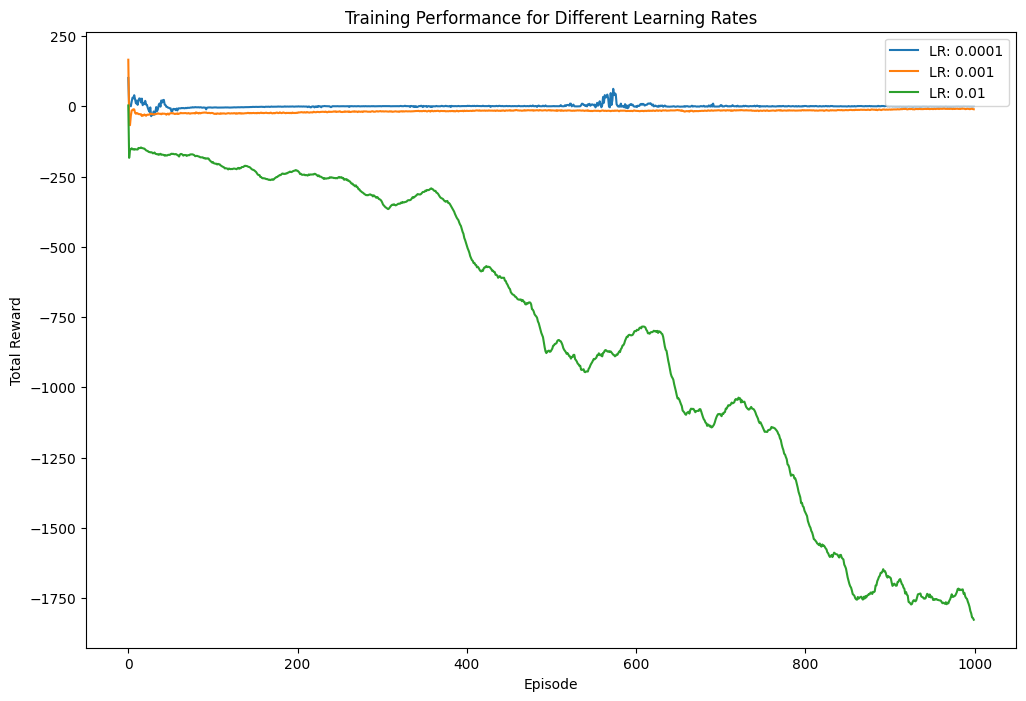

In [24]:
if __name__ == "__main__":
    env = gym.make('CustomHopper-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    learning_rates = [1e-4, 1e-3, 1e-2]
    num_episodes = 1000
    max_steps = 1000

    all_rewards = {}

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        policy = Policy(state_dim, action_dim)
        agent = Agent(policy, lr=lr)
        episode_rewards = train(env, agent, num_episodes, max_steps)
        all_rewards[lr] = episode_rewards

    plt.figure(figsize=(12, 8))
    for lr, rewards in all_rewards.items():
        plt.plot(rewards, label=f"LR: {lr}")
    plt.title('Training Performance for Different Learning Rates')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()

    env.close()


Training with learning rate: 0.001
Episode 10, Average Reward: -284.04
Episode 20, Average Reward: -186.05
Episode 30, Average Reward: -153.98
Episode 40, Average Reward: -149.83
Episode 50, Average Reward: -150.81
Episode 60, Average Reward: -148.01
Episode 70, Average Reward: -145.61
Episode 80, Average Reward: -144.90
Episode 90, Average Reward: -146.07
Episode 100, Average Reward: -144.96
Episode 110, Average Reward: -144.56
Episode 120, Average Reward: -144.45
Episode 130, Average Reward: -144.29
Episode 140, Average Reward: -144.38
Episode 150, Average Reward: -142.92
Episode 160, Average Reward: -142.27
Episode 170, Average Reward: -142.05
Episode 180, Average Reward: -142.14
Episode 190, Average Reward: -141.83
Episode 200, Average Reward: -141.40
Episode 210, Average Reward: -141.28
Episode 220, Average Reward: -139.64
Episode 230, Average Reward: -139.64
Episode 240, Average Reward: -139.10
Episode 250, Average Reward: -138.21
Episode 260, Average Reward: -136.18
Episode 270,

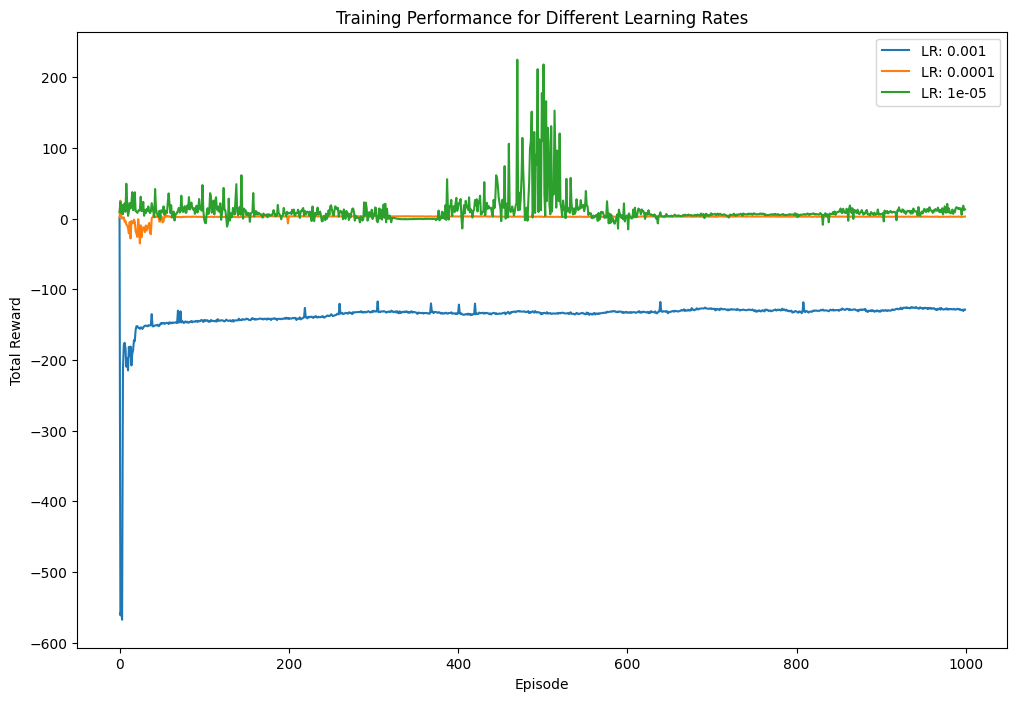

In [26]:
if __name__ == "__main__":
    env = gym.make('CustomHopper-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    learning_rates = [1e-3, 1e-4, 1e-5]
    num_episodes = 1000
    max_steps = 1000

    all_rewards = {}

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        policy = Policy(state_dim, action_dim)
        agent = Agent(policy, lr=lr)
        episode_rewards = train(env, agent, num_episodes, max_steps)
        all_rewards[lr] = episode_rewards

    plt.figure(figsize=(12, 8))
    for lr, rewards in all_rewards.items():
        plt.plot(rewards, label=f"LR: {lr}")
    plt.title('Training Performance for Different Learning Rates')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()

    env.close()


# Testing with different learning rates for actor and critic
The Agent class now initializes two separate optimizers, optimizer_actor and optimizer_critic, for the actor and critic networks respectively.
Update Policy: The update_policy method now zeroes out, backpropagates, and updates the actor and critic networks separately

In [18]:
def bootstrapped_discount_rewards(r, gamma, done, next_values):
    bootstrapped_discounted_r = torch.zeros_like(r)
    for t in reversed(range(0, r.size(-1))):
         if done[t]:
             bootstrapped_discounted_r[t] = r[t]
         else:
             bootstrapped_discounted_r[t] = r[t] + gamma*next_values[t]
    return bootstrapped_discounted_r

In [25]:
class Agent(object):
    def __init__(self, policy, actor_lr, critic_lr, device='cpu'):
        self.train_device = device
        self.policy = policy.to(self.train_device)
        self.optimizer_actor = torch.optim.Adam([param for name, param in policy.named_parameters() if 'actor' in name], lr=actor_lr)
        self.optimizer_critic = torch.optim.Adam([param for name, param in policy.named_parameters() if 'critic' in name], lr=critic_lr)

        self.gamma = 0.99
        self.states = []
        self.next_states = []
        self.action_log_probs = []
        self.rewards = []
        self.done = []

    def update_policy(self):
        action_log_probs = torch.stack(self.action_log_probs, dim=0).to(self.train_device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(self.train_device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        done = torch.Tensor(self.done).to(self.train_device)

        self.states, self.next_states, self.action_log_probs, self.rewards, self.done = [], [], [], [], []

        #Compute bootstrapped discount estimates
        ## compute estimated values of the current state and of the next state
        _, v_currentstate = self.policy(states)
        _, v_nextstate = self.policy(next_states)
        ## bootstrapped discounted returns r_t+gamma*V(s_t+1)*(1-done)
        bootstrapped_discount_r = bootstrapped_discount_rewards(rewards, self.gamma, done, v_nextstate)

        #Compute advantage terms (TD error)
        advantages = bootstrapped_discount_r - v_currentstate.detach()
        ## .detach() is used to ensure that the value estimates used in the advantage calculation do not contribute to the gradient
        ## computations for updating the policy.
        
        #Compute actor and critic loss
        actor_loss = -(action_log_probs * advantages.detach()).mean()
        critic_loss =  torch.mean((bootstrapped_discount_r - v_currentstate) ** 2)

        #compute gradients
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()
        ## backproagate the total loss
        actor_loss.backward(retain_graph=True)
        critic_loss.backward()

        #Step optimizer
        self.optimizer_actor.step()
        self.optimizer_critic.step()

    def get_action(self, state, evaluation=False):
        x = torch.from_numpy(state).float().to(self.train_device)
        normal_dist, _ = self.policy(x)

        if evaluation:
            return normal_dist.mean, None
        else:
            action = normal_dist.sample()
            action_log_prob = normal_dist.log_prob(action).sum()
            return action, action_log_prob

    def store_outcome(self, state, next_state, action_log_prob, reward, done):
        self.states.append(torch.from_numpy(state).float())
        self.next_states.append(torch.from_numpy(next_state).float())
        self.action_log_probs.append(action_log_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.done.append(done)


Trying computing the mean reward of every episode (instead of doing it every 10 episodes) and testing only the cases in which the actor RL is different from the critic RL

In [26]:
def train(env, agent, num_episodes, max_steps):
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action, action_log_prob = agent.get_action(state)
            next_state, reward, done, _ = env.step(action.numpy())
            
            agent.store_outcome(state, next_state, action_log_prob, reward, done)
            episode_reward += reward
            state = next_state

            if done:
                break

        agent.update_policy()
        episode_rewards.append(episode_reward)

        avg_reward = np.mean(episode_rewards)
        print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}")
        
    return episode_rewards

Training with Actor LR: 0.0001, Critic LR: 0.0005
Episode 1, Average Reward: 7.75
Episode 2, Average Reward: 7.97
Episode 3, Average Reward: 9.94
Episode 4, Average Reward: 9.11
Episode 5, Average Reward: 8.90
Episode 6, Average Reward: 8.02
Episode 7, Average Reward: 7.81
Episode 8, Average Reward: 7.20
Episode 9, Average Reward: 7.03
Episode 10, Average Reward: 6.83
Episode 11, Average Reward: 6.48
Episode 12, Average Reward: 7.14
Episode 13, Average Reward: 7.52
Episode 14, Average Reward: 7.16
Episode 15, Average Reward: 7.28
Episode 16, Average Reward: 7.03
Episode 17, Average Reward: 6.93
Episode 18, Average Reward: 7.00
Episode 19, Average Reward: 8.48
Episode 20, Average Reward: 8.29
Episode 21, Average Reward: 8.68
Episode 22, Average Reward: 8.44
Episode 23, Average Reward: 8.29
Episode 24, Average Reward: 8.72
Episode 25, Average Reward: 8.50
Episode 26, Average Reward: 8.55
Episode 27, Average Reward: 8.61
Episode 28, Average Reward: 8.46
Episode 29, Average Reward: 8.49
Ep

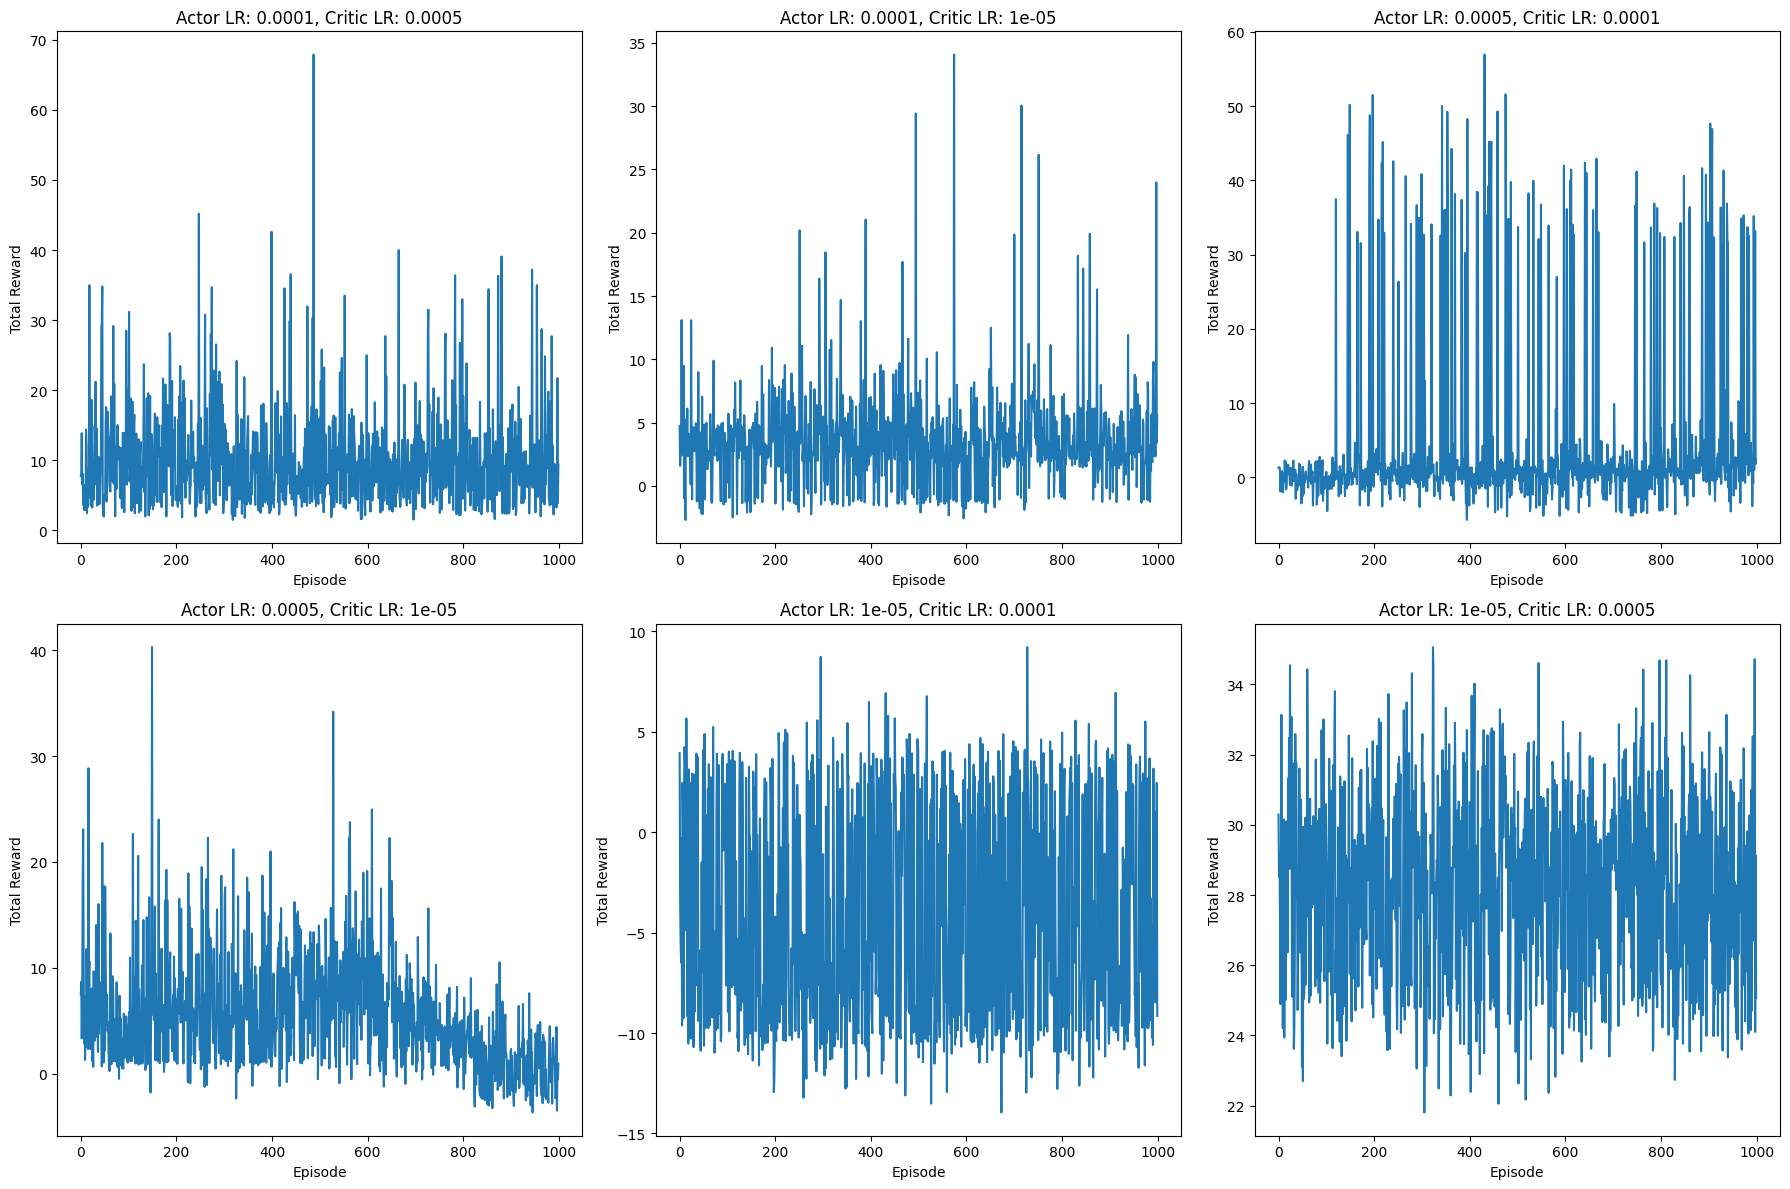

In [27]:
if __name__ == "__main__":
    env = gym.make('CustomHopper-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    learning_rates = [1e-4, 5e-4, 1e-5]
    num_episodes = 1000
    max_steps = 1000

    all_rewards = {}
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten()

    plot_idx = 0
    for actor_lr in learning_rates:
        for critic_lr in learning_rates:
            if actor_lr != critic_lr:
                print(f"Training with Actor LR: {actor_lr}, Critic LR: {critic_lr}")
                policy = Policy(state_dim, action_dim)
                agent = Agent(policy, actor_lr=actor_lr, critic_lr=critic_lr)
                episode_rewards = train(env, agent, num_episodes, max_steps)
                all_rewards[(actor_lr, critic_lr)] = episode_rewards

                axs[plot_idx].plot(episode_rewards, label=f"Actor LR: {actor_lr}, Critic LR: {critic_lr}")
                axs[plot_idx].set_title(f"Actor LR: {actor_lr}, Critic LR: {critic_lr}")
                axs[plot_idx].set_xlabel('Episode')
                axs[plot_idx].set_ylabel('Total Reward')
                plot_idx += 1

    plt.tight_layout()
    plt.show()

    env.close()

We opt for **actor LR=5e-4, critic LR 1e-4** as it has the highest rewards with better stability